In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
external_data = pd.read_csv(Path("external_data") / 'external_data.csv')
data = pd.read_parquet(Path("data") / "train.parquet")

In [3]:
print(external_data['date'].min(), external_data['date'].max())

2020-09-01 00:00:00 2021-10-21 12:00:00


In [4]:
external_data_cleaned = external_data.dropna(axis=1, how='all').sort_values(by='date')

In [ ]:
# Defin columns of interests, transfer to to_datetime and celsius format
columns_of_interest = ["date", "etat_sol", "dd", "ff", "t", "u", "vv", "n", "ht_neige", "rr3"]

external_data_sorted = external_data_cleaned[columns_of_interest].copy()

external_data_sorted["date"] = pd.to_datetime(external_data_sorted['date'])
external_data_sorted.loc[:, "t"] = external_data_sorted["t"] - 273.15

# Set additionnal informations on time periods and wind direction
def set_periods(df, column_name, periods):
    df[column_name] = 0
    for start_date, end_date in periods:
        df.loc[(df['date'] >= start_date) & (df['date'] < end_date), column_name] = 1

lockdown_periods = [('2020-10-30', '2020-12-15'),
                    ('2021-04-03', '2021-05-04')]

soft_curfew_periods = [('2020-10-17', '2020-10-30'),
                       ('2020-12-15', '2021-01-16'),
                       ('2021-05-19', '2021-06-21')]

hard_curfew_periods = [('2021-01-16', '2021-04-03'),
                       ('2021-05-04', '2021-05-19')]


bank_holidays = pd.to_datetime([
    '2020-11-01', '2020-11-11', '2020-12-25', '2021-01-01', '2021-04-05',
    '2021-05-01', '2021-05-13', '2021-05-24', '2021-07-14', '2021-08-15'])


holidays = [('2020-10-17', '2020-11-02'),
            ('2020-12-19', '2021-01-02'),
            ('2021-02-13', '2021-03-01'),
            ('2021-04-17', '2021-05-03'),
            ('2021-10-23', '2021-11-08')]

set_periods(external_data_sorted, 'Lockdown', lockdown_periods)
set_periods(external_data_sorted, 'soft-curfew', soft_curfew_periods)
set_periods(external_data_sorted, 'hard-curfew', hard_curfew_periods)
external_data_sorted['bank_holidays'] = external_data_sorted['date'].isin(bank_holidays).astype(int)
set_periods(external_data_sorted, 'holidays', holidays)


def set_headings(df, column_names, bearings):
    for column_name, (low_bearing, high_bearing) in zip(column_names, bearings):
        df[column_name] = 0
        df.loc[(df['dd'] >= low_bearing) & (df['dd'] < high_bearing), column_name] = 1

# For computation ease, we do not set the North column, as it is described by the other three
column_names = ["East", "South", "West"]
bearings = [(45, 135), (135, 225), (225, 315)]

set_headings(external_data_sorted, column_names, bearings)
external_data_sorted = external_data_sorted.drop(columns=["dd"])


print(external_data_sorted.head())

                    date  etat_sol   ff     t   u     vv     n  ht_neige  rr3  \
3082 2020-09-01 00:00:00       0.0  1.6  12.6  81  30000   0.0       0.0  0.0   
3083 2020-09-01 03:00:00       0.0  1.1  10.8  88  25000   0.0       0.0  0.0   
3084 2020-09-01 06:00:00       0.0  1.8  11.1  91  25000  10.0       0.0  0.0   
3085 2020-09-01 09:00:00       0.0  2.9  18.1  60  19830  25.0       0.0  0.0   
3086 2020-09-01 12:00:00       0.0  2.6  20.8  44  21000   NaN       0.0  0.0   

      East  South  West  Lockdown  soft-curfew  hard-curfew  bank_holidays  \
3082     0      0     0         0            0            0              0   
3083     0      0     1         0            0            0              0   
3084     0      0     0         0            0            0              0   
3085     0      0     0         0            0            0              0   
3086     0      0     0         0            0            0              0   

      holidays  
3082         0  
3083      

In [ ]:
# Let's fill missing hours : we will create new lines, which will be copies of the existing lines
def create_missing_hours(row):
    new_rows = []

    # copy = existing line minus two hours
    new_row_2h = row.copy()
    new_row_2h['date'] = row['date'] - pd.Timedelta(hours=2)
    new_rows.append(new_row_2h)

    # copy = existing line minus one hour
    new_row_1h = row.copy()
    new_row_1h['date'] = row['date'] - pd.Timedelta(hours=1)
    new_rows.append(new_row_1h)

    return new_rows


new_rows = []
for index, row in external_data_sorted.iterrows():
    new_rows.extend(create_missing_hours(row))


new_data = pd.DataFrame(new_rows)

external_data_expanded = pd.concat([external_data_sorted, new_data], ignore_index=True)
external_data_expanded = external_data_expanded.sort_values(by='date').reset_index(drop=True)


print(external_data_expanded.head())

                 date  etat_sol   ff     t   u     vv    n  ht_neige  rr3  \
0 2020-08-31 22:00:00       0.0  1.6  12.6  81  30000  0.0       0.0  0.0   
1 2020-08-31 23:00:00       0.0  1.6  12.6  81  30000  0.0       0.0  0.0   
2 2020-09-01 00:00:00       0.0  1.6  12.6  81  30000  0.0       0.0  0.0   
3 2020-09-01 01:00:00       0.0  1.1  10.8  88  25000  0.0       0.0  0.0   
4 2020-09-01 02:00:00       0.0  1.1  10.8  88  25000  0.0       0.0  0.0   

   East  South  West  Lockdown  soft-curfew  hard-curfew  bank_holidays  \
0     0      0     0         0            0            0              0   
1     0      0     0         0            0            0              0   
2     0      0     0         0            0            0              0   
3     0      0     1         0            0            0              0   
4     0      0     1         0            0            0              0   

   holidays  
0         0  
1         0  
2         0  
3         0  
4         0  


In [7]:
data_train = pd.merge(data, external_data_expanded, on='date', how='inner')

In [8]:
def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    X["year"] = X["date"].dt.year
    X["month"] = X["date"].dt.month
    X["day"] = X["date"].dt.day
    X["weekday"] = X["date"].dt.weekday
    X["hour"] = X["date"].dt.hour

    return X

external_data_train = _encode_dates(data_train)
external_data_train.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,...,Lockdown,soft-curfew,hard-curfew,bank_holidays,holidays,year,month,day,weekday,hour
0,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0,0,0,0,0,2020,9,1,1,2
1,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0,0,0,0,0,2020,9,1,1,3
2,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0,0,0,0,0,2020,9,1,1,4
3,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0,0,0,0,0,2020,9,1,1,15
4,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,...,0,0,0,0,0,2020,9,1,1,18


In [9]:
y = external_data_train["log_bike_count"]
X = external_data_train.drop(
    columns=["log_bike_count", "bike_count", "site_id", "counter_name", "site_name",
             "coordinates", "counter_technical_id", "counter_installation_date"])

In [10]:
X = pd.get_dummies(X, columns=["counter_id"], dummy_na=True, drop_first=True, prefix_sep=' ')
X.drop(columns=["counter_id nan"], inplace=True)

In [11]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):

    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train.drop(columns=["date"]), y_train.drop(columns=["date"]), X_valid.drop(columns=["date"]), y_valid.drop(columns=["date"])

In [12]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

In [ ]:
import xgboost as xgb
from sklearn.metrics import r2_score

boost = xgb.XGBRegressor(random_state=0)
boost.fit(X_train, y_train)

y_pred = boost.predict(X_valid)
score = r2_score(y_valid, y_pred)
print("R² Score:", score)

R² Score: 0.8784969690334632


In [14]:
import xgboost as xgb
from sklearn.metrics import r2_score

boost_v2 = xgb.XGBRegressor(learning_rate=0.13, max_depth=7, min_child_weight=3,
                            n_estimators=300, subsample=1, random_state=0)


boost_v2.fit(X_train, y_train)


y_pred2 = boost_v2.predict(X_valid)

score2 = r2_score(y_valid, y_pred2)

print("R² Score2:", score2)

R² Score2: 0.8881889704667776


In [15]:
from sklearn.metrics import root_mean_squared_error

print(f"Train set, RMSE={root_mean_squared_error(y_train, boost_v2.predict(X_train)):.4f}")
print(f"Test set, RMSE={root_mean_squared_error(y_valid, boost_v2.predict(X_valid)):.4f}")

print(f"Train set, RMSE={root_mean_squared_error(y_train, boost.predict(X_train)):.4f}")
print(f"Test set, RMSE={root_mean_squared_error(y_valid, boost.predict(X_valid)):.4f}")

Train set, RMSE=0.3742
Test set, RMSE=0.4820
Train set, RMSE=0.4444
Test set, RMSE=0.5024


In [16]:
from sklearn.model_selection import learning_curve

N, train_score, val_score = learning_curve(boost_v2, X_train, y_train, train_sizes=np.linspace(0.2, 1, 5), cv=5)

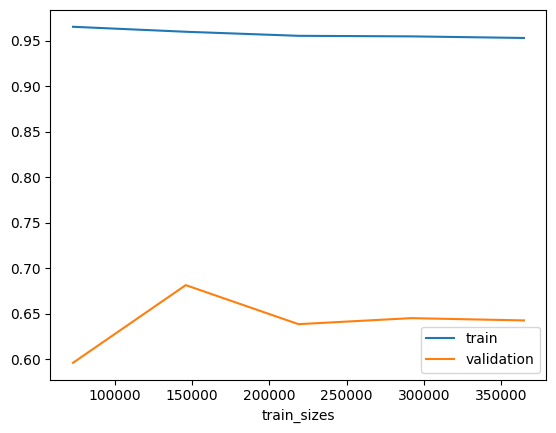

In [17]:
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()